In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
import cv2
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
# Check GPU
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)

assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# import package
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Input, Dense, Dropout, Activation,
                                     Flatten, BatchNormalization, Conv2D,
                                     MaxPooling2D)
from tensorflow.keras.applications.inception_v3 import (InceptionV3,
                                                        preprocess_input)
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from tensorflow.keras import initializers

In [4]:
data_path = "training_set"

x_data_list = []
y_data_list = []
for roots, dirs, files in os.walk(data_path):
    for each in files:
        if each.find('checkpoint') == -1:
            x_data_list.append(os.path.join(roots, each))
            y_data_list.append(roots.split("/")[-1])

In [5]:
#read image size
def list_img_size(data_list):
    size_list=[]
    for each in tqdm(data_list):
        img=cv2.imread(each,1)
        size_list.append(img.shape)
    return size_list

100%|██████████| 538/538 [00:05<00:00, 104.92it/s]

637
[637 324   3]
637


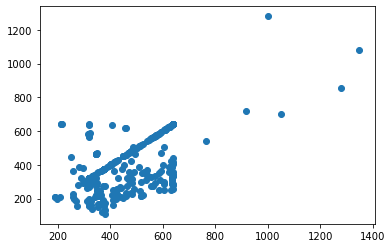

In [6]:
size_list=list_img_size(x_data_list)

print(max(size_list[3]))
size_arr=np.array(size_list)
print(size_arr[3])
print(max(size_arr[3]))
plt.scatter(size_arr[:,0],size_arr[:,1])

In [7]:
img_size=300
def preprocess_img(img):
    new_size=img_size
    resize_ratio=new_size/max(img.shape)
    new_img_size=(int(img.shape[1]*resize_ratio),int(img.shape[0]*resize_ratio))
    img=cv2.resize(img,new_img_size)
    top=int((new_size-img.shape[0])/2)
    bottom=new_size-(top+img.shape[0])
    left=int((new_size-img.shape[1])/2)
    right=new_size-(left+img.shape[1])
    img=cv2.copyMakeBorder(img,top,bottom,left,right,cv2.BORDER_REPLICATE)
    return img
    

(637, 324, 3)
(300, 300, 3)


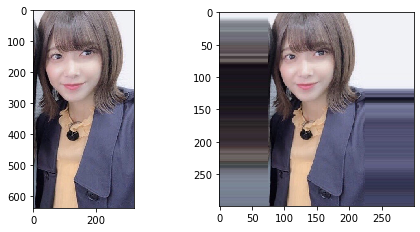

In [8]:
img=cv2.imread(x_data_list[3])
print(img.shape)
new_img=preprocess_img(img)
print(new_img.shape)
plt.figure(figsize=(16, 8))
plt.subplot(2, 4, 1)
plt.imshow(img[...,::-1])
# plt.axis('off')
plt.subplot(2, 4, 2)
plt.imshow(new_img[...,::-1])
# plt.axis('off')
plt.show()

In [9]:

def load_img(data_list):
    data_img = []
    for each in tqdm(data_list):
        img = cv2.imread(each,1)
        img=preprocess_img(img)
#         data_img.append(img[..., np.newaxis])
        data_img.append(img)

    return np.array(data_img).astype('float32')/255.

In [10]:
x_data = load_img(x_data_list)

100%|██████████| 538/538 [00:05<00:00, 92.79it/s] 


(300, 300, 3)
(300, 300, 3)


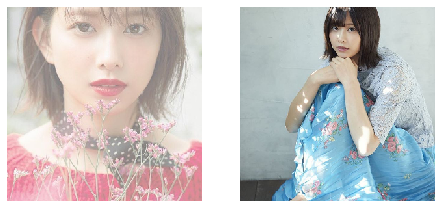

In [11]:
# show image
plt.figure(figsize=(16, 8))
for i in range(2):
    print(x_data[i].shape)
    plt.subplot(2, 4, i+1)
    plt.imshow(x_data[i][..., ::-1], cmap='gray')
#     plt.imshow(x_data[i][..., 0], cmap='gray')
    
    plt.axis('off')
plt.show()

In [12]:
y_data_list = pd.DataFrame(y_data_list, columns=['label'])
uniques = y_data_list['label'].value_counts().index
counts = y_data_list['label'].value_counts().values

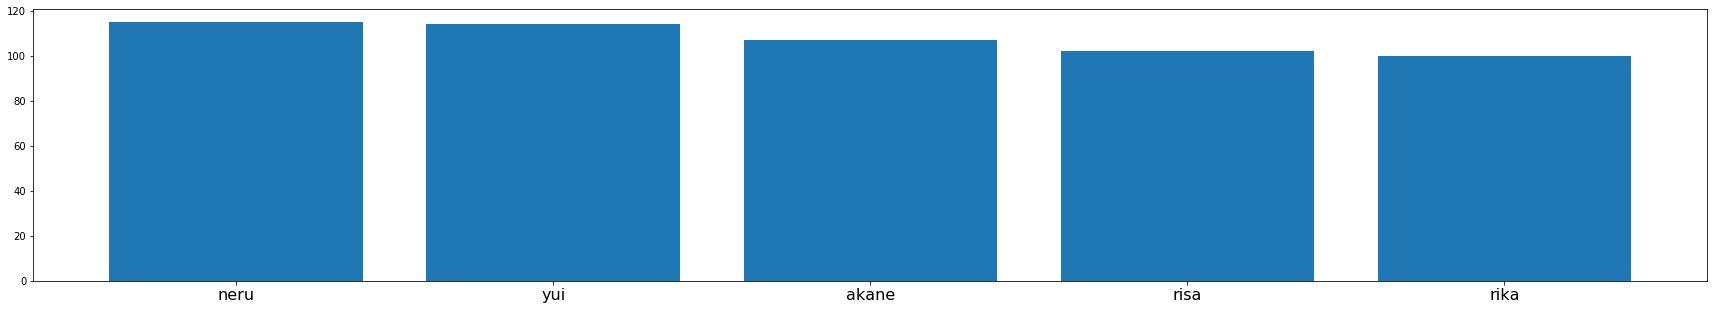

In [13]:
plt.figure(figsize=(30, 5))
plt.bar(uniques, counts)
plt.xticks(fontsize=16)
plt.show()

In [14]:
class_path = "/Midterm_Exam/CNN_who_is_she/"
# class_map = pd.read_csv(os.path.join(class_path, 'classmap.csv'),
#                         header=None, index_col=0)
class_map=pd.read_csv('classmap.csv',index_col='classname')
print(class_map)
class_map = class_map.to_dict()
mapp=class_map['classnum']

           classnum
classname          
rika              0
risa              1
yui               2
akane             3
neru              4


In [15]:
y_data_list
y_data = y_data_list['label'].map(mapp).values.copy()

In [16]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data,
                                                    test_size=0.1,
                                                    shuffle=True,
                                                    random_state=20)
#                                                     stratify=y_data)

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train,
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=20)
#                                                     stratify=y_train)



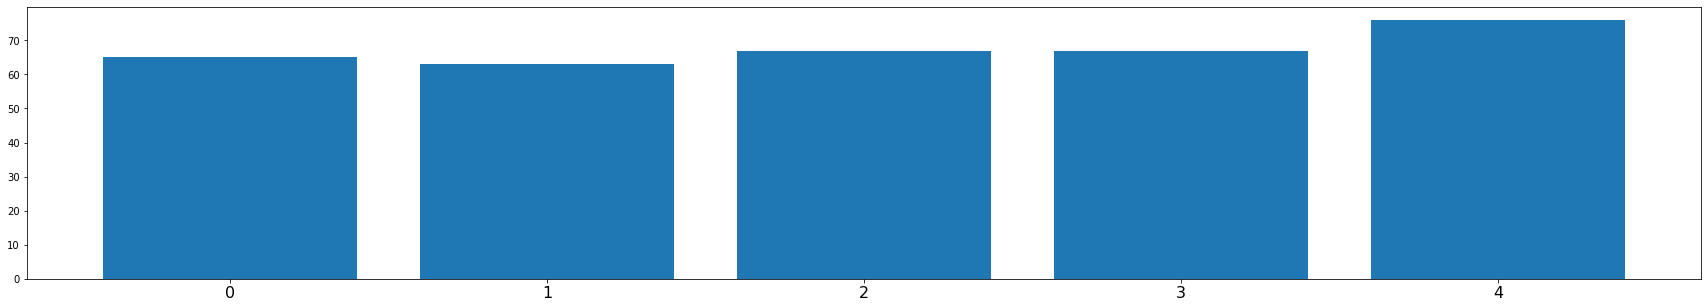

In [17]:
uniques, counts = np.unique(y_train, return_counts=True)

plt.figure(figsize=(30, 5))
plt.bar(uniques, counts)
plt.xticks(fontsize=16)
plt.show()

In [18]:
num_classes = len(uniques)

y_train = np.eye(num_classes, dtype='float32')[y_train]
y_test = np.eye(num_classes, dtype='float32')[y_test]
y_valid= np.eye(num_classes, dtype='float32')[y_valid]
print('y_train shape:', y_train.shape)

y_train shape: (338, 5)


In [19]:
initial = initializers.he_normal()
inputs = Input(shape=x_train.shape[1:])
print(x_train.shape[1:])

(300, 300, 3)


In [20]:
pre_model = InceptionV3(weights='imagenet', include_top=False,
                        input_shape=(img_size, img_size, 3))

x = GlobalAveragePooling2D()(pre_model.output)
# x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)


model = Model(inputs=pre_model.inputs, outputs=outputs)

In [21]:
pre_model.trainable = True

# trainable_layer = 10
# for layer in pre_model.layers[:-trainable_layer]:
#     layer.trainable = False

# for layer in model.layers:
#     print(layer, layer.trainable)

# model.summary()

In [22]:
model_dir = './Model/IncV3-logs'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

logfiles = model_dir + '/{}-{}'.format('basic_model',
                                       model.__class__.__name__)
model_cbk = keras.callbacks.TensorBoard(log_dir=logfiles,
                                        histogram_freq=0)

modelfiles = model_dir + '/{}-best-model.h5'.format('basic_model')
model_mckp = keras.callbacks.ModelCheckpoint(modelfiles,
                                             monitor='val_accuracy',
                                             save_best_only=True)

earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                          patience=10,
                                          verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', verbose=1,factor=0.5,
                              patience=3, min_lr=0.00001)


callbacks_list = [model_cbk, model_mckp, earlystop,reduce_lr]
# callbacks_list = [model_cbk, model_mckp,reduce_lr]

In [23]:
learning_rate = 0.001
optimizer = keras.optimizers.Adam(lr=learning_rate)

model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

In [24]:
batch_size = 32
epochs = 50
num_step = (x_train.shape[0]*3) // batch_size
datagen = ImageDataGenerator(
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=False,
                             fill_mode='nearest',
#                              rotation_range=15,
                             cval=0,
                             )

In [25]:
from sklearn.utils import class_weight
classes_to_predict = sorted(np.unique(y_train.argmax(-1)))
class_weights = class_weight.compute_class_weight("balanced", classes_to_predict, y_train.argmax(-1))
class_weights_dict = {i : class_weights[i] for i,label in enumerate(classes_to_predict)}

In [ ]:
history = model.fit_generator(datagen.flow(x_train, y_train,
                                               batch_size=batch_size),
                                  steps_per_epoch=num_step,
                                  epochs=epochs,
                                  shuffle=True,
                                  validation_data=(x_valid, y_valid),
                                  class_weight=class_weights_dict,
                                  callbacks=callbacks_list
                                 )

Epoch 1/50
31/31 [==============================] - 30s 955ms/step - loss: 1.1134 - accuracy: 0.5934 - val_loss: 12.2242 - val_accuracy: 0.1918
Epoch 2/50
31/31 [==============================] - 27s 872ms/step - loss: 0.5209 - accuracy: 0.8316 - val_loss: 3.1796 - val_accuracy: 0.2397
Epoch 3/50
31/31 [==============================] - 24s 777ms/step - loss: 0.3195 - accuracy: 0.8979 - val_loss: 10.1553 - val_accuracy: 0.1849
Epoch 4/50
31/31 [==============================] - 27s 873ms/step - loss: 0.3323 - accuracy: 0.8985 - val_loss: 1.6311 - val_accuracy: 0.3219
Epoch 5/50
31/31 [==============================] - 26s 827ms/step - loss: 0.1831 - accuracy: 0.9398 - val_loss: 2.4553 - val_accuracy: 0.4932
Epoch 6/50
31/31 [==============================] - 25s 795ms/step - loss: 0.2497 - accuracy: 0.9180 - val_loss: 5.1376 - val_accuracy: 0.4315
Epoch 7/50
30/31 [============================>.] - ETA: 0s - loss: 0.2513 - accuracy: 0.9237
Epoch 00007: ReduceLROnPlateau reducing learni

In [ ]:
train_history = ['loss', 'val_loss', 'accuracy', 'val_accuracy']
name_history = ['training_loss', 'val_loss', 'training_acc', 'val_acc']
plt.figure(figsize=(12, 5))
for eachx, eachy, i in zip(train_history, name_history, range(4)):
    if i % 2 == 0:
        plt.subplot(1, 2, i//2+1)
    l_x = len(history.history[eachx])
    plt.plot(np.arange(l_x), history.history[eachx], label=eachy)
    plt.legend(loc='best')
    plt.title('IncV3 ' + eachy)
plt.show()

In [ ]:
model.save('./Model/IncV3-logs/who_is_she.h5')

In [ ]:
model_test = keras.models.load_model('./Model/IncV3-logs/basic_model-best-model.h5')
loss, acc = model_test.evaluate(x_test, y_test, verbose=2)
y_pred = model_test.predict(x_test)
y_pred = y_pred.argmax(-1)

print(accuracy_score(y_test.argmax(-1), y_pred))
print(confusion_matrix(y_test.argmax(-1), y_pred))

In [ ]:
class_names = np.array([each for each in class_map.keys()])
matrix = confusion_matrix(y_test.argmax(-1), y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(matrix, annot=True, cbar=False, cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
data_path = "testing_set"

test_data_list = []
id_list=[]
for roots, dirs, files in os.walk(data_path):
    for each in files:
        if each.find('checkpoint') == -1:
            test_data_list.append(os.path.join(roots, each))
            id_list.append(each.split('.')[0])
len(test_data_list)

In [ ]:
x_test_data = load_img(test_data_list)

In [ ]:
# show image
plt.figure(figsize=(16, 8))
for i in range(2):
    print(x_test_data[i].shape)
    plt.subplot(2, 4, i+1)
    plt.imshow(x_test_data[i][..., ::-1], cmap='gray')
#     plt.imshow(x_data[i][..., 0], cmap='gray')
    
    plt.axis('off')
plt.show()

In [ ]:
y_predict=model_test.predict(x_test_data)

In [ ]:
y_label = np.argmax(y_predict, axis=1) # 取機率值最高的類別當作預測結果
print(y_label)
print(type(y_label))
print(y_label.shape)
print(type(id_list))
print(len(id_list))
list_ans=list(zip(id_list,y_label))
df_ans=pd.DataFrame(list_ans,columns=['id','class'])
df_ans.to_csv('who_is_she(IncV3).csv',index=0)